<a href="https://colab.research.google.com/github/ArunK-ML/Project---Shopper-Spectrum-Customer-Segmentation-and-Product-Recommendations-in-E-Commerce/blob/main/Streamlit/Shopper_Spectrum_Streamlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%writefile streamlit_app.py

import json
import difflib
import numpy as np
import pandas as pd
import streamlit as st
import joblib
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ===============================
# Page Configuration
# ===============================
st.set_page_config(
    page_title='Shopper Spectrum',
    page_icon='🛒',
    layout='wide',
    initial_sidebar_state='collapsed'
)

# ===============================
# Custom CSS Styling
# ===============================
st.markdown("""
<style>
    /* Import Google Fonts */
    @import url('https://fonts.googleapis.com/css2?family=Inter:wght@300;400;500;600;700&display=swap');

    /* Global Styles */
    .main {
        padding-top: 2rem;
    }

    /* Custom font */
    html, body, [class*="css"] {
        font-family: 'Inter', sans-serif;
    }

    /* Header styling */
    .main-header {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        padding: 2rem;
        border-radius: 15px;
        margin-bottom: 2rem;
        text-align: center;
        color: white;
        box-shadow: 0 10px 30px rgba(0,0,0,0.1);
    }

    .main-title {
        font-size: 2.5rem;
        font-weight: 700;
        margin-bottom: 0.5rem;
        text-shadow: 2px 2px 4px rgba(0,0,0,0.3);
    }

    .main-subtitle {
        font-size: 1.2rem;
        font-weight: 300;
        opacity: 0.9;
    }

    /* Card styling */
    .feature-card {
        background: white;
        padding: 2rem;
        border-radius: 15px;
        box-shadow: 0 5px 20px rgba(0,0,0,0.08);
        border: 1px solid #f0f2f6;
        margin-bottom: 2rem;
        transition: transform 0.3s ease, box-shadow 0.3s ease;
    }

    .feature-card:hover {
        transform: translateY(-5px);
        box-shadow: 0 10px 30px rgba(0,0,0,0.12);
    }

    /* Tab styling */
    .stTabs [data-baseweb="tab-list"] {
        gap: 2rem;
        background: #f8fafc;
        padding: 0.5rem;
        border-radius: 10px;
    }

    .stTabs [data-baseweb="tab"] {
        background: transparent;
        border-radius: 8px;
        padding: 0.75rem 1.5rem;
        font-weight: 500;
        border: none;
    }

    .stTabs [aria-selected="true"] {
        background: white;
        box-shadow: 0 2px 10px rgba(0,0,0,0.1);
    }

    /* Button styling */
    .stButton > button {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        color: white;
        border: none;
        border-radius: 8px;
        padding: 0.75rem 2rem;
        font-weight: 500;
        transition: all 0.3s ease;
        box-shadow: 0 4px 15px rgba(102, 126, 234, 0.4);
    }

    .stButton > button:hover {
        transform: translateY(-2px);
        box-shadow: 0 6px 20px rgba(102, 126, 234, 0.6);
    }

    /* Input styling */
    .stTextInput > div > div > input {
        border-radius: 8px;
        border: 2px solid #e2e8f0;
        transition: border-color 0.3s ease;
    }

    .stTextInput > div > div > input:focus {
        border-color: #667eea;
        box-shadow: 0 0 0 3px rgba(102, 126, 234, 0.1);
    }

    /* Metric styling */
    .metric-container {
        background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%);
        padding: 1.5rem;
        border-radius: 12px;
        text-align: center;
        color: white;
        margin-bottom: 1rem;
    }

    .metric-value {
        font-size: 2rem;
        font-weight: 700;
        margin-bottom: 0.5rem;
    }

    .metric-label {
        font-size: 0.9rem;
        opacity: 0.9;
        font-weight: 400;
    }

    /* Success/Error messages */
    .stSuccess {
        background: linear-gradient(135deg, #84fab0 0%, #8fd3f4 100%);
        border: none;
        border-radius: 10px;
    }

    .stError {
        background: linear-gradient(135deg, #fa709a 0%, #fee140 100%);
        border: none;
        border-radius: 10px;
    }

    /* Chart containers */
    .chart-container {
        background: white;
        border-radius: 15px;
        padding: 1.5rem;
        box-shadow: 0 5px 20px rgba(0,0,0,0.08);
        margin: 1rem 0;
    }
</style>
""", unsafe_allow_html=True)

# ===============================
# Header Section
# ===============================
st.markdown("""
<div class="main-header">
    <div class="main-title">🛒 Shopper Spectrum</div>
    <div class="main-subtitle">Advanced Customer Analytics & Intelligent Product Recommendations</div>
</div>
""", unsafe_allow_html=True)

# ===============================
# Load artifacts (with error handling)
# ===============================
@st.cache_data
def load_data():
    try:
        # Load models and data
        scaler = joblib.load('/content/scaler.pkl')
        kmeans = joblib.load('/content/kmeans_model.pkl')
        with open('cluster_label_map.json','r') as f:
            cluster_label_map = json.load(f)

        clean_df = pd.read_csv('/content/online_retail.csv', parse_dates=['InvoiceDate'])
        product_master = pd.read_csv('product_master.csv')
        item_item_sim = np.load('item_item_sim.npy')
        item_list = np.load('item_list.npy', allow_pickle=True)
        rfm_segments = pd.read_csv('rfm_with_segments.csv')

        return scaler, kmeans, cluster_label_map, clean_df, product_master, item_item_sim, item_list, rfm_segments
    except Exception as e:
        st.error(f"Error loading data files: {str(e)}")
        st.info("Please ensure all required files are in the same directory as this script.")
        st.stop()

# Load data
scaler, kmeans, cluster_label_map, clean_df, product_master, item_item_sim, item_list, rfm_segments = load_data()

# ===============================
# Sidebar with Key Metrics
# ===============================
with st.sidebar:
    st.markdown("### 📊 Quick Stats")

    col1, col2 = st.columns(2)

    total_customers = len(rfm_segments)
    total_products = len(product_master)

    st.markdown(f"""
    <div class="metric-container">
        <div class="metric-value">{total_customers:,}</div>
        <div class="metric-label">Total Customers</div>
    </div>
    """, unsafe_allow_html=True)

    st.markdown(f"""
    <div class="metric-container">
        <div class="metric-value">{total_products:,}</div>
        <div class="metric-label">Products</div>
    </div>
    """, unsafe_allow_html=True)

    # Top segments
    st.markdown("### 🎯 Top Segments")
    top_segments = rfm_segments['Segment'].value_counts().head(3)
    for segment, count in top_segments.items():
        st.markdown(f"**{segment}**: {count:,} customers")

# ===============================
# Main Tabs
# ===============================
rec_tab, seg_tab, insights_tab = st.tabs(["🔎 Product Recommendations", "👥 Customer Segmentation", "📈 Business Insights"])

# -------------------------------
# Product Recommendation Tab
# -------------------------------
with rec_tab:
    st.markdown('<div class="feature-card">', unsafe_allow_html=True)

    col1, col2 = st.columns([2, 1])

    with col1:
        st.subheader('🎯 Smart Product Discovery')
        st.markdown("Find products similar to what you're looking for using our advanced recommendation engine.")

        # Search interface
        search_col1, search_col2 = st.columns([3, 1])
        with search_col1:
            all_names = product_master['Description'].fillna('').astype(str).tolist()
            user_input = st.text_input('🔍 Enter a product name', placeholder='e.g., "white ceramic mug" or "christmas decoration"')

        with search_col2:
            topn = st.selectbox('Results', [5, 10, 15, 20], index=0)

    with col2:
        # Popular products showcase
        st.markdown("### 🔥 Trending Products")
        if 'popularity_qty' in product_master.columns:
            popular = product_master.nlargest(3, 'popularity_qty')[['Description', 'popularity_qty']]
            for idx, row in popular.iterrows():
                st.markdown(f"**{row['Description'][:30]}...**")
                st.markdown(f"*{row['popularity_qty']} sold*")
                st.markdown("---")

    # Search button and results
    if st.button('🚀 Get Recommendations', use_container_width=True):
        if user_input.strip() == '':
            st.warning('💡 Please enter a product name to get started!')
        else:
            with st.spinner('Finding similar products...'):
                matches = difflib.get_close_matches(user_input, all_names, n=5, cutoff=0.4)

                if len(matches) == 0:
                    st.error('🚫 No similar products found. Try using different keywords or check spelling.')

                    # Suggest popular alternatives
                    st.info("💡 Here are some popular products you might like:")
                    popular_suggestions = product_master.nlargest(5, 'popularity_qty')[['Description', 'StockCode']]
                    st.dataframe(popular_suggestions, use_container_width=True, hide_index=True)
                else:
                    # Show matches found
                    st.success(f'✅ Found {len(matches)} similar products!')

                    with st.expander("🔍 See all matches"):
                        for i, match in enumerate(matches, 1):
                            st.write(f"{i}. {match}")

                    chosen_name = matches[0]
                    chosen_row = product_master[product_master['Description'] == chosen_name].head(1)

                    if len(chosen_row) == 0:
                        st.error('❌ Selected product not found in our database.')
                    else:
                        chosen_code = chosen_row['StockCode'].iloc[0]

                        try:
                            idx = np.where(item_list == chosen_code)[0][0]
                            sims = item_item_sim[idx]
                            top_idx = np.argsort(-sims)
                            top_idx = [i for i in top_idx if i != idx][:int(topn)]
                            rec_codes = item_list[top_idx]

                            # Get recommendations with similarity scores
                            recs = product_master[product_master['StockCode'].isin(rec_codes)][['StockCode','Description','popularity_qty']].copy()

                            # Add similarity scores
                            similarity_scores = []
                            for code in recs['StockCode']:
                                code_idx = np.where(item_list == code)[0][0]
                                similarity_scores.append(f"{sims[code_idx]:.2f}")

                            recs['Similarity'] = similarity_scores
                            recs = recs.sort_values('Similarity', ascending=False)

                            st.markdown("### 🎉 Recommended Products")

                            # Display recommendations in a nice format
                            for idx, row in recs.iterrows():
                                col1, col2, col3 = st.columns([3, 1, 1])
                                with col1:
                                    st.markdown(f"**{row['Description']}**")
                                    st.caption(f"Code: {row['StockCode']}")
                                with col2:
                                    st.metric("Similarity", f"{row['Similarity']}")
                                with col3:
                                    st.metric("Popularity", f"{row['popularity_qty']}")
                                st.divider()

                        except Exception as e:
                            st.error('❌ This product is not available in our recommendation system.')
                            st.info("💡 Try searching for a different product.")

    st.markdown('</div>', unsafe_allow_html=True)

# -------------------------------
# Customer Segmentation Tab
# -------------------------------
with seg_tab:
    st.markdown('<div class="feature-card">', unsafe_allow_html=True)

    # RFM Prediction Section
    col1, col2 = st.columns([2, 1])

    with col1:
        st.subheader('🎯 Customer Segment Predictor')
        st.markdown("Enter RFM values to predict customer segment and get insights.")

        # RFM input in a nice layout
        rfm_col1, rfm_col2, rfm_col3 = st.columns(3)

        with rfm_col1:
            st.markdown("**📅 Recency**")
            r_in = st.number_input('Days since last purchase', min_value=0, value=30, step=1, help="Lower values indicate more recent customers")

        with rfm_col2:
            st.markdown("**🔄 Frequency**")
            f_in = st.number_input('Number of purchases', min_value=0, value=5, step=1, help="Higher values indicate more loyal customers")

        with rfm_col3:
            st.markdown("**💰 Monetary**")
            m_in = st.number_input('Total spend ($)', min_value=0.0, value=100.0, step=10.0, help="Total amount spent by the customer")

    with col2:
        st.markdown("### 🧠 RFM Guide")
        st.markdown("""
        **Recency**: How recently did the customer purchase?
        - Lower = Better (recent customers)

        **Frequency**: How often do they purchase?
        - Higher = Better (loyal customers)

        **Monetary**: How much do they spend?
        - Higher = Better (valuable customers)
        """)

    if st.button('🔮 Predict Segment', use_container_width=True):
        with st.spinner('Analyzing customer profile...'):
            X = np.array([[r_in, f_in, m_in]], dtype=float)
            X_scaled = scaler.transform(X)
            cluster_id = int(kmeans.predict(X_scaled)[0])
            label = cluster_label_map.get(str(cluster_id), f'Cluster {cluster_id}')

            # Create a nice results display
            col1, col2, col3 = st.columns(3)

            with col2:
                st.markdown(f"""
                <div class="metric-container">
                    <div class="metric-value">{label}</div>
                    <div class="metric-label">Predicted Segment</div>
                </div>
                """, unsafe_allow_html=True)

            # Show segment characteristics
            segment_customers = rfm_segments[rfm_segments['Segment'] == label]
            if not segment_customers.empty:
                st.markdown("### 📊 Segment Characteristics")

                char_col1, char_col2, char_col3, char_col4 = st.columns(4)

                with char_col1:
                    avg_recency = segment_customers['Recency'].mean()
                    st.metric("Avg Recency", f"{avg_recency:.0f} days")

                with char_col2:
                    avg_frequency = segment_customers['Frequency'].mean()
                    st.metric("Avg Frequency", f"{avg_frequency:.1f}")

                with char_col3:
                    avg_monetary = segment_customers['Monetary'].mean()
                    st.metric("Avg Monetary", f"${avg_monetary:.0f}")

                with char_col4:
                    segment_size = len(segment_customers)
                    st.metric("Segment Size", f"{segment_size:,}")

    st.markdown('</div>', unsafe_allow_html=True)

    # Segment Overview Section
    st.markdown('<div class="feature-card">', unsafe_allow_html=True)
    st.subheader("📊 Customer Segments Overview")

    seg_counts = rfm_segments['Segment'].value_counts().reset_index()
    seg_counts.columns = ['Segment', 'CustomerCount']

    # Create a beautiful bar chart with Plotly
    fig = px.bar(
        seg_counts,
        x='Segment',
        y='CustomerCount',
        title="Customer Distribution by Segment",
        color='CustomerCount',
        color_continuous_scale='viridis'
    )

    fig.update_layout(
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        font_family="Inter",
        title_font_size=20,
        showlegend=False
    )

    st.plotly_chart(fig, use_container_width=True)


# -------------------------------
# Business Insights Tab
# -------------------------------
with insights_tab:
    st.markdown('<div class="feature-card">', unsafe_allow_html=True)

    st.subheader("📈 Business Intelligence Dashboard")

    # Key metrics row
    metric_col1, metric_col2, metric_col3, metric_col4 = st.columns(4)

    with metric_col1:
        total_revenue = rfm_segments['Monetary'].sum()
        st.metric("Total Revenue", f"${total_revenue:,.0f}")

    with metric_col2:
        avg_order_value = rfm_segments['Monetary'].mean()
        st.metric("Avg Customer Value", f"${avg_order_value:.0f}")

    with metric_col3:
        avg_frequency = rfm_segments['Frequency'].mean()
        st.metric("Avg Purchase Frequency", f"{avg_frequency:.1f}")

    with metric_col4:
        avg_recency = rfm_segments['Recency'].mean()
        st.metric("Avg Days Since Purchase", f"{avg_recency:.0f}")

    # Segment analysis
    col1, col2 = st.columns(2)

    with col1:
        st.markdown("### 💰 Revenue by Segment")
        segment_revenue = rfm_segments.groupby('Segment')['Monetary'].sum().reset_index()
        segment_revenue = segment_revenue.sort_values('Monetary', ascending=False)

        fig = px.pie(
            segment_revenue,
            values='Monetary',
            names='Segment',
            title="Revenue Distribution by Segment"
        )

        fig.update_layout(
            plot_bgcolor='rgba(0,0,0,0)',
            paper_bgcolor='rgba(0,0,0,0)',
            font_family="Inter"
        )

        st.plotly_chart(fig, use_container_width=True)

    with col2:
        st.markdown("### 📊 RFM Heatmap")

        # Create RFM correlation heatmap
        rfm_corr = rfm_segments[['Recency', 'Frequency', 'Monetary']].corr()

        fig = px.imshow(
            rfm_corr,
            title="RFM Variables Correlation",
            color_continuous_scale="RdBu_r",
            aspect="auto"
        )

        fig.update_layout(
            plot_bgcolor='rgba(0,0,0,0)',
            paper_bgcolor='rgba(0,0,0,0)',
            font_family="Inter"
        )

        st.plotly_chart(fig, use_container_width=True)

    st.markdown('</div>', unsafe_allow_html=True)

# ===============================
# Footer
# ===============================
st.markdown("---")
st.markdown("""
<div style="text-align: center; padding: 2rem; color: #64748b;">
    <p>🛒 <strong>Shopper Spectrum</strong> — Powered by Advanced Analytics & Machine Learning</p>
    <p><em>Built with Streamlit • RFM Analysis • K-Means Clustering • Collaborative Filtering</em></p>
</div>
""", unsafe_allow_html=True)

Writing streamlit_app.py


In [ ]:
!pip install streamlit streamlit_option_menu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.3/829.3 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 129.5 MB/s eta 0:00:00


In [ ]:
!wget -q -O - ipv4.icanhazip.com

35.223.170.55


In [ ]:
!streamlit run streamlit_app.py & npx localtunnel --port 8501

⠙⠹⠸

⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.223.170.55:8501

⠦⠧Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇your url is: https://flat-lizards-eat.loca.lt


In [6]:
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

# 1. Load trained model
model = joblib.load("/content/kmeans_model.pkl")
scaler = joblib.load("/content/rfm_scaler.pkl") # Load the fitted scaler

# 2. Example input (replace values with real customer data)
# Suppose your dataset had features like ['Quantity', 'UnitPrice', 'TotalAmount', 'Frequency']
# 5. Example new input (raw values, unscaled)
new_customer = {
    "Recency": 30,    # days since last purchase
    "Frequency": 10,  # number of transactions
    "Monetary": 500   # total spend
}

# ⚠️ IMPORTANT:
# Since your model was trained on *scaled* columns,
# you must apply the same scaling to new input before predicting.
# Let's reuse StandardScaler fitted on training data.


# Transform new input
new_df = pd.DataFrame([new_customer])
new_scaled = scaler.transform(new_df)

# 6. Predict cluster for new customer
segment = model.predict(new_scaled)[0]
print(f"✅ Predicted Segment (Cluster): {segment}")

✅ Predicted Segment (Cluster): 2


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [7]:
import pandas as pd
import joblib

# 1. Load trained model + scaler
model = joblib.load("/content/kmeans_model.pkl")
scaler = joblib.load("/content/rfm_scaler.pkl")  # Your saved scaler

# 2. Load your dataset
df = pd.read_csv("/content/online_retail_cleaned_after_normalize.csv")

# Select features used in clustering
X = df[["Recency", "Frequency", "Monetary"]]

# Scale features (must match training preprocessing)
X_scaled = scaler.transform(X)

# Predict clusters for all rows
df["Cluster"] = model.predict(X_scaled)

# 3. Example new customer (raw values, unscaled)
new_customer = {
    "Recency": 30,    # days since last purchase
    "Frequency": 10,  # number of transactions
    "Monetary": 500   # total spend
}

# Transform new input
new_df = pd.DataFrame([new_customer])
new_scaled = scaler.transform(new_df)

# 4. Predict cluster for new customer
segment = model.predict(new_scaled)[0]
print(f"✅ Predicted Segment (Cluster): {segment}")

# 5. Get products/customers from same cluster
same_cluster = df[df["Cluster"] == segment]

print(f"\n🔹 Total customers in same cluster: {same_cluster.shape[0]}")

# If you want product list (assuming 'Description' column exists)
if "Description" in same_cluster.columns:
    product_list = same_cluster["Description"].value_counts().head(10)
    print("\n🔹 Top Products in this Segment:")
    print(product_list)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Predicted Segment (Cluster): 2

🔹 Total customers in same cluster: 392200

🔹 Top Products in this Segment:
Description
WHITE HANGING HEART T-LIGHT HOLDER    2005
REGENCY CAKESTAND 3 TIER              1701
JUMBO BAG RED RETROSPOT               1593
ASSORTED COLOUR BIRD ORNAMENT         1396
PARTY BUNTING                         1381
LUNCH BAG RED RETROSPOT               1302
SET OF 3 CAKE TINS PANTRY DESIGN      1147
LUNCH BAG  BLACK SKULL.               1094
POSTAGE                               1074
PACK OF 72 RETROSPOT CAKE CASES       1054
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(



✅ Predicted Segment (Cluster): 2

🔹 Cluster Size: 392200 customers out of 392200

🔹 Cluster Profile (average values):
Recency      2.747730
Frequency    1.635929
Monetary     5.069087
dtype: float64

🔹 Top Products in this Segment:
Description
WHITE HANGING HEART T-LIGHT HOLDER    2005
REGENCY CAKESTAND 3 TIER              1701
JUMBO BAG RED RETROSPOT               1593
ASSORTED COLOUR BIRD ORNAMENT         1396
PARTY BUNTING                         1381
Name: count, dtype: int64


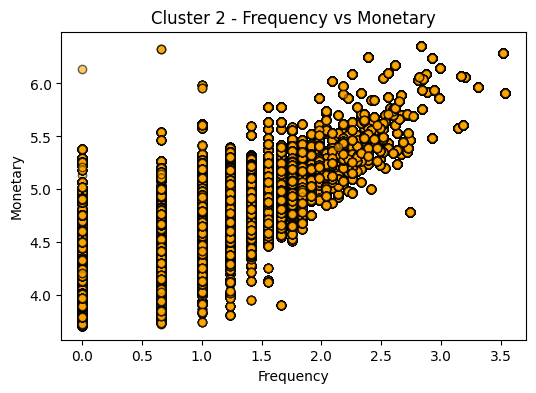

In [8]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# Load model + scaler
model = joblib.load("/content/kmeans_model.pkl")
scaler = joblib.load("/content/rfm_scaler.pkl")

# Load dataset
df = pd.read_csv("/content/online_retail_cleaned_after_normalize.csv")
X = df[["Recency","Frequency","Monetary"]]
X_scaled = scaler.transform(X)
df["Cluster"] = model.predict(X_scaled)

# New customer example
new_customer = {"Recency":30,"Frequency":10,"Monetary":500}
new_df = pd.DataFrame([new_customer])
new_scaled = scaler.transform(new_df)
segment = model.predict(new_scaled)[0]
print(f"\n✅ Predicted Segment (Cluster): {segment}")

# Same cluster subset
same_cluster = df[df["Cluster"]==segment]

# Cluster size
print(f"\n🔹 Cluster Size: {same_cluster.shape[0]} customers out of {df.shape[0]}")

# Cluster profile
cluster_profile = same_cluster[["Recency","Frequency","Monetary"]].mean()
print("\n🔹 Cluster Profile (average values):")
print(cluster_profile)

# Top products
if "Description" in same_cluster.columns:
    top_products = same_cluster["Description"].value_counts().head(5)
    print("\n🔹 Top Products in this Segment:")
    print(top_products)

# Visualization
plt.figure(figsize=(6,4))
plt.scatter(same_cluster["Frequency"], same_cluster["Monetary"], alpha=0.6, c="orange", edgecolor="k")
plt.title(f"Cluster {segment} - Frequency vs Monetary")
plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.show()


In [10]:
# --------------------------
# 🔹 Function: Search product
# --------------------------
def search_product(product_name, df):
    # Find matching products (case-insensitive, partial match)
    matches = df[df["Description"].str.contains(product_name, case=False, na=False)]

    if matches.empty:
        print(f"❌ No product found matching: {product_name}")
        return None

    # Get clusters for those products
    cluster_counts = matches["Cluster"].value_counts()
    print(f"\n✅ Product search: '{product_name}'")
    print("Clusters where this product appears:")
    print(cluster_counts)

    # Show related products from top cluster
    top_cluster = cluster_counts.index[0]
    related_products = df[df["Cluster"]==top_cluster]["Description"].value_counts().head(10)
    print(f"\n🔹 Related Products in Cluster {top_cluster}:")
    print(related_products)

    return matches

# --------------------------
# Example: Search a product
# --------------------------
search = input("Enter Product name")
results = search_product(search, df)

if results is not None:
    print("\n🔹 Sample Matching Rows:")
    print(results[["Description","Cluster"]].head())

Enter Product namebook

✅ Product search: 'book'
Clusters where this product appears:
Cluster
2    6021
Name: count, dtype: int64

🔹 Related Products in Cluster 2:
Description
WHITE HANGING HEART T-LIGHT HOLDER    2005
REGENCY CAKESTAND 3 TIER              1701
JUMBO BAG RED RETROSPOT               1593
ASSORTED COLOUR BIRD ORNAMENT         1396
PARTY BUNTING                         1381
LUNCH BAG RED RETROSPOT               1302
SET OF 3 CAKE TINS PANTRY DESIGN      1147
LUNCH BAG  BLACK SKULL.               1094
POSTAGE                               1074
PACK OF 72 RETROSPOT CAKE CASES       1054
Name: count, dtype: int64

🔹 Sample Matching Rows:
                      Description  Cluster
352    JAZZ HEARTS PURSE NOTEBOOK        2
549  SET OF 3 NOTEBOOKS IN PARCEL        2
569  SET OF 3 NOTEBOOKS IN PARCEL        2
734           GREEN FERN NOTEBOOK        2
735         BLUE PAISLEY NOTEBOOK        2
